# Jupyter Version of Creating_Slits.py

In [ ]:
# These codes are developed by Panchajanya Dey, Indian Institute of Science, Bangalore
# as a part of the SRFP project prominence oscillation in solar corona funded by Indian Academy of Science (2023)
# this folder contains the codes are for downloading the necessary fits files, modifying them by multi-gaussian image processing
# and creating an animation that helps to identify the location of the prominence oscillation
# the next part is to determine the pixel coordinates and creating a 4-pixel wide slit and get the corresponding XT map
# which is also covered in this project
# finally handpicking the prominence oscillation from the XT map and fitting it to a damped harmonic oscillation is done
# the final result is the period, damping time and amplitude determination for a LAL prominence oscillation
# I thank Prof. Vaibhav Pant (ARIES) and his group member Upasna Baweja (ARIES) for helping me throughout the project
# and clearing my doubts
# for comments, suggestions and clarity regarding the code contact at the following email address
# panchajanyad@iisc.ac.in

0.1057443618774414
Time data exists 

3500
104098
Intensity data exists 

3500
[0.6037744303513972, 0.2714042129579882, 0.25403824783698803, 0.1784064196803469, 0.4425216942231474, 0.4912005919806423, 0.5511346506465122, 0.2985218331292014, 0.49379206805360026, 0.4192958656198675, 0.15579286585077595, 0.09403112987716458, 0.31290490459189885, 0.3784809246327622, 0.5221327298169698, 0.4515924461841441, 0.1985535220996288, 0.15799255592608225, 0.169505165720811, 0.18132915014919868, 0.22770440750257848, 0.048418870455075036, 0.16331090274367094, 0.1051977444272568, 0.13108555913777517, 0.28971516153224636, 0.1183045729794307, 0.08539580383086307, 0.08710435612316017, 0.16693023844495108, 0.07556127428997658, 0.08838012291078595, 0.3475595082927885, 0.2568401651379404, 0.2956905326491515, 0.2577445449257381, 0.24172165878338403, 0.09047540671124049, 0.16001332097368764, 0.13114347319562866, 0.22572734057258717, 0.11367239848132699, 0.19527414403186158, 0.13989124718571333, 0.1276347369713

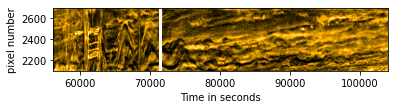

In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import matplotlib.pyplot as plt
import sunpy.visualization.colormaps
from scipy import ndimage
from astropy.io import fits
import time
from scipy.interpolate import CubicSpline
import os

path = r"E:\SRFP\Python and Jupyter\FITS Files"

###########################

start = time.time()

# pixel choice
x_data = [2350,2396,2464,2521]
y_data = [1173,1200,1227,1266]

x_data = np.array(x_data)
y_data = np.array(y_data)

# Create the cubic spline interpolation function
cubic_interpolation = CubicSpline(x_data, y_data)

x_values = np.arange(2350,2521,1,dtype='int')
y_values = cubic_interpolation(x_values)
y_values = np.array(y_values,dtype='int')

#############################

# necessary functions
# creating a gaussian kernel
def gaussian_kernel(sigma):
    kernel_size = int(2 * np.ceil(2 * sigma) + 1)
    offset = int(kernel_size // 2)
    kernel = [[(1 / (2 * np.pi * sigma ** 2)) * np.exp(-((x - offset) ** 2 + (y - offset) ** 2) / (2 * sigma ** 2)) for x in range(kernel_size)] for y in range(kernel_size)]
    #normalise the kernel
    sum_kernel = sum(sum(kernel,[]))
    kernel = [[element / sum_kernel for element in row] for row in kernel]
    return kernel
    
# gaussian normalisation
def mgn(data,sigma,k):
    blur_data = ndimage.convolve(data, gaussian_kernel(sigma))
    sharp_data = data-blur_data
    squared_sharp = np.square(sharp_data)
    data_standard_deviation = np.sqrt(ndimage.convolve(squared_sharp,gaussian_kernel(sigma)))
    mask = data_standard_deviation == data_standard_deviation.min()
    data_standard_deviation[mask]=10**-6
    mgn_data_0 = sharp_data/data_standard_deviation
    mgn_data = np.arctan(k*mgn_data_0)
    return mgn_data

def global_gamma_trans(data,gamma):
    a0 = data.min()
    a1 = data.max()
    data_1 = ((data-a0)/(a1-a0))**(1/gamma)
    return data_1

# to extract single pixel width slit data
def slit_data(file_path):
    with fits.open(file_path) as file:
        header = file[0].header
        hdul = file[0].data
    data = hdul.copy()
    xmin = 2100
    xmax = 2700
    ymin = 1000
    ymax = 1400
    data_cropped = data[ymin:ymax,xmin:xmax]
    bias = 0
    for i in range(len(data_cropped)):
        for j in range(len(data_cropped[i])):
            if data_cropped[i][j]<bias:
                data_cropped[i][j] = bias
    A = 0.7*global_gamma_trans(data_cropped,3.2)+(1-0.7)/5*(0.91*mgn(data_cropped,1.25,0.7)+0.976*mgn(data_cropped,2.5,0.7)+0.994*mgn(data_cropped,5,0.7)+0.998*mgn(data_cropped,10,0.7)+0.999*mgn(data_cropped,20,0.7))
    B = []
    for x,y in zip(x_values,y_values):
        #print(x,y)
        B.append(A[y-ymin,x-xmin])
    return B

#############################

# choosing slit
slit_name = 'slit_0'
slit_x = [2350,2396,2464,2521]
slit_y = [1173,1200,1227,1266]
with open(r"E:\SRFP\Python and Jupyter\Slit_Info\Slit Points\\"+slit_name+'_points.txt','w') as f:
    for x,y in zip(slit_x,slit_y):
        f.write(str(x)+' : '+str(y))
        f.write('\n')

x_data = np.array(slit_x)
y_data = np.array(slit_y)

# Create the cubic spline interpolation function
cubic_interpolation = CubicSpline(x_data, y_data)

x_values = np.arange(2350,2521,1,dtype='int')
y_values = cubic_interpolation(x_values)
y_values = np.array(y_values,dtype='int')

####################################

# show the slit position in an image
if not os.path.isfile(r"E:\SRFP\Python and Jupyter\Slit_Info\Position of Slit\\"+slit_name+".png"):
    fits_image_filename0 = r"E:\SRFP\Python and Jupyter\FITS Files\\"+'AIA20160126_184410_0171.fits'
    with fits.open(fits_image_filename0) as file:
        hdul0 = file[0].data
    data0 = hdul0.copy()
    bias0 = 0
    for i in range(len(data0)):
        for j in range(len(data0[i])):
            if data0[i][j]<bias0:
                data0[i][j] = bias0
    xmin0 = 2300
    xmax0 = 3700
    ymin0 = 400
    ymax0 = 2000
    data_cropped0 = data0[ymin0:ymax0,xmin0:xmax0]
    A0 = 0.7*global_gamma_trans(data_cropped0,3.2)+(1-0.7)/5*(0.91*mgn(data_cropped0,1.25,0.7)+0.976*mgn(data_cropped0,2.5,0.7)+0.994*mgn(data_cropped0,5,0.7)+0.998*mgn(data_cropped0,10,0.7)+0.999*mgn(data_cropped0,20,0.7))
    print(time.time()-start)
    plt.imshow(A0,cmap = 'sdoaia171', origin='lower',vmin = A0.min(),vmax = A0.max(), extent=[xmin0, xmax0, ymin0, ymax0])
    plt.plot(slit_x,slit_y,'r+')
    plt.plot(x_values,y_values,'r')
    plt.savefig(r"E:\SRFP\Python and Jupyter\Slit_Info\Position of Slit\\"+slit_name+".png")
print(time.time()-start)

############################################

# check if the slit data already exists
if os.path.isfile(r"E:\SRFP\Python and Jupyter\Slit_Info\Time_files\\"+slit_name+"_time.txt"):
    print('Time data exists \n')
    with open(r"E:\SRFP\Python and Jupyter\Slit_Info\Time_files\\"+slit_name+"_time.txt",'r') as ftime:
        time_data = ftime.readlines()
    t = []
    for item in time_data:
        t.append(int(item.split()[0]))
    print(len(t))
    print(t[-1])
else:
    print('Time data does not exist \n')
    t = []

if os.path.isfile(r"E:\SRFP\Python and Jupyter\Slit_Info\Intensity_files\\"+slit_name+"_intensity.txt"):
    print('Intensity data exists \n')
    with open(r"E:\SRFP\Python and Jupyter\Slit_Info\Intensity_files\\"+slit_name+"_intensity.txt",'r') as fint:
        B = fint.readlines()
    Intensity = []
    for b in B:
        Intensity.append([])
        bt = b.replace('\n','')[1:-2].split(',')
        for item in bt:
            try:
                Intensity[-1].append(float(item))
            except ValueError:
                Intensity[-1].append(float('nan'))
    print(len(Intensity))
    print(Intensity[-1])
else:
    print('Intensity data does not exist \n')
    Intensity = []

############################################

# extracting slit data from each file
files = sorted(os.listdir(r"E:\SRFP\Python and Jupyter\FITS Files"))
n = 0
nf = 3500
with open(r"E:\SRFP\Python and Jupyter\Slit_Info\Time_files\\"+slit_name+"_time.txt",'w') as ftime:
    with open(r"E:\SRFP\Python and Jupyter\Slit_Info\Intensity_files\\"+slit_name+"_intensity.txt",'w') as fint:
        if len(t)!=0:
            for t0 in t:
                ftime.write(str(t0))
                ftime.write('\n')
        if len(Intensity)!=0:
            for intensity in Intensity:
                fint.write(str(intensity))
                fint.write('\n')

        for f in files[n:nf]:
            path = r"E:\SRFP\Python and Jupyter\FITS Files\\"+f
            print(f+' : '+str(n)+' : '+str(time.time()-start))
            n+=1
            t0 = (int(f[10])-6)*86400+int(f[12:14])*3600+int(f[14:16])*60+int(f[16:18])
            if t0 not in t:
                slit_data_obtained = slit_data(path)
                Intensity.append(slit_data_obtained)
                fint.write(str(slit_data_obtained))
                fint.write('\n')
                t.append(t0)
                ftime.write(str(t0))
                ftime.write('\n')

xmin = 2100
xmax = 2700
ymin = 1000
ymax = 1400



<IPython.core.display.Javascript object>


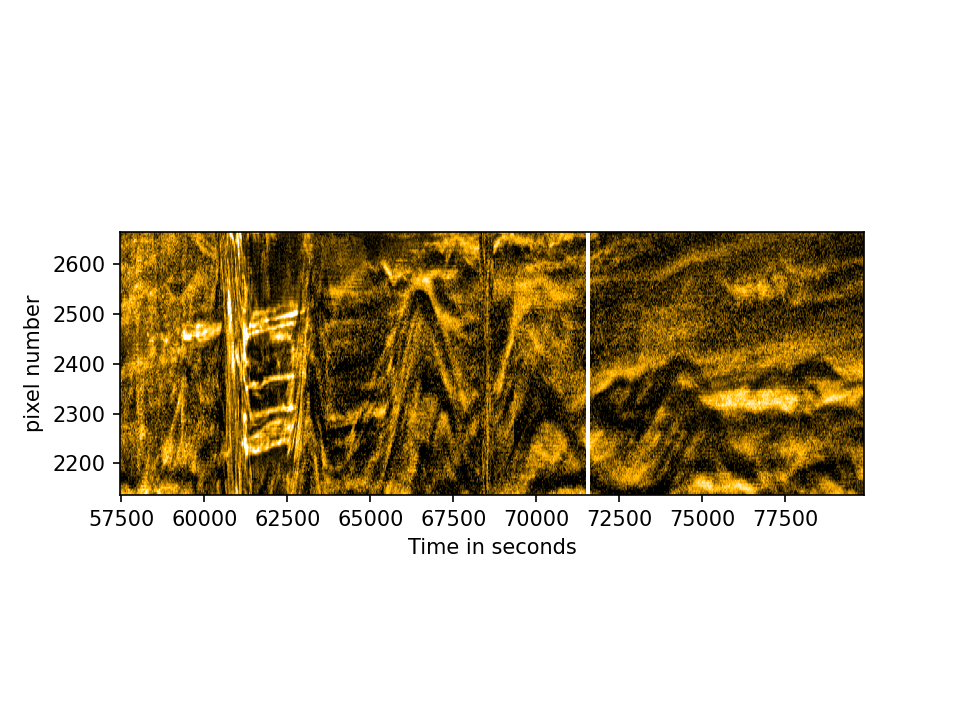

In [2]:
%matplotlib notebook
# plotting slit data
plt.imshow(np.transpose(Intensity),aspect=15,cmap = 'sdoaia171', origin='lower',vmin = min(Intensity[-1]),vmax = max(Intensity[-1]),extent=[t[0], t[-1], xmin, xmax])
plt.ylabel('pixel number')
plt.xlabel('Time in seconds')
plt.savefig(r"E:\SRFP\Python and Jupyter\Slit_Info\xt map\\"+slit_name+"_xtmap.png")
plt.show()